# License

MIT License

Copyright (c) 2024 cmacklin@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# Importing Required Packages

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from sklearn.model_selection import train_test_split
!pip install scikeras
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools

# Load Data

In [20]:
#files available at https://www.kaggle.com/competitions/digit-recognizer/data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Image Pre-processing

In [21]:
Y_train = train["label"] #save labels to Y_train variable
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0  #normalize image values
test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1) #reshape image to size (28,28)
test = test.values.reshape(-1,28,28,1)
Y_train = tf.one_hot(Y_train, depth=10) #one-hot encode label values

In [22]:
X_train_np = X_train.numpy() if hasattr(X_train, 'numpy') else X_train #save X_train as numpy array
Y_train_np = Y_train.numpy() if hasattr(Y_train, 'numpy') else Y_train

In [23]:
#spit data into training and validation data sets with 80/20 split
trainX, testX, trainY, testY = train_test_split(X_train_np, Y_train_np, test_size=0.2, random_state=42)

# Train CNN Model

In [ ]:
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1))) #conv layer with relu activation and 32 filters
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform')) #conv layer with relu activation and 32 filters
	model.add(MaxPooling2D((2, 2))) #pooling layer to reduce dimensions
	model.add(Dropout(0.1))  #add dropout layer for regularization
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform')) #conv layer with relu activation and 64 filters
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform')) #conv layer with relu activation and 64 filters
	model.add(MaxPooling2D((2, 2))) #pooling layer to reduce dimensions
	model.add(Dropout(0.1))  #add dropout layer for regularization
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform')) #conv layer with relu activation and 128 filters
	model.add(MaxPooling2D((2, 2))) #pooling layer to reduce dimensions
	model.add(Dropout(0.1))  #add dropout layer for regularization
	model.add(Flatten())  #flatten before dense layer
	model.add(Dense(10, activation='softmax')) #dense layer with softmax activation and 10 outputs for each digit
	# compile model
	model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
	return model

'''
loss is 'categorical_crossentropy' because label values are one-hot encoded
'accuracy' is the test metric defined by kaggle
'''

model = define_model()
history = model.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=0) #hyperparameters: epochs=10, batch_size=64
_, acc = model.evaluate(testX, testY, verbose=0) #evaluate model on validation data


print('Accuracy:',acc)

In [25]:
_, acc = model.evaluate(trainX, trainY, verbose=0)  #evaluate model on training data
print('Train Accuracy:',acc)

Train Accuracy: 0.9991964101791382


In [26]:
#find auc score for training and validation data
y_pred = model.predict(testX)
y_pred_train = model.predict(trainX)
auc = roc_auc_score(trainY, y_pred_train, multi_class='ovr')
print(f"Train Overall AUC: {auc}")
auc = roc_auc_score(testY, y_pred, multi_class='ovr')
print(f"Valid Overall AUC: {auc}")

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Train Overall AUC: 0.9999935514004467
Valid Overall AUC: 0.999972640632578


# Architecture Summary

In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 2, 2, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 280,278 (1.07 MB)

 Trainable params: 140,138 (547.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 140,140 (547.43 KB)

# Confusion Matrix of Model Results




263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


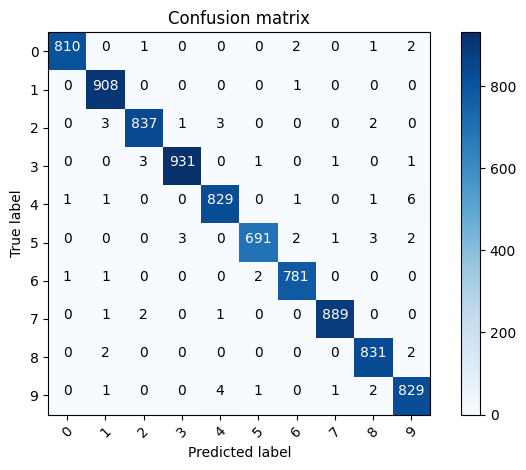

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

predY = model.predict(testX)
predYclasses = np.argmax(predY,axis = 1)  # convert predictions classes to one hot vectors
Y_true = np.argmax(testY,axis = 1) # convert validation observations to one hot vectors
confusion_mtx = confusion_matrix(Y_true, predYclasses)
plot_confusion_matrix(confusion_mtx, classes = range(10)) #plot

# Create and Export Submission File

In [28]:
predictions = np.argmax(model.predict(test), axis=1)

submission = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Submission file saved as 'submission.csv'
